In [1]:
import os
import pandas as pd
from pathlib import Path

# Define the data folder path
data_folder = Path('DataCollectionFolderMRIProject')

prefixes = ['00', 'A3', 'A6', 'D3', 'G3', 'G6']

# collect all matching files
csv_files = []

# For '00': N1 to N4
csv_files.extend([f"MRI3Tesla_00N{i}.csv" for i in range(1, 5)])

# For others: each prefix has N1 and N2
for pref in prefixes[1:]:  # skip '00' since already handled
    csv_files.extend([f"MRI3Tesla_{pref}N1.csv", f"MRI3Tesla_{pref}N2.csv"])

# Now filter to only existing files
existing_files = [f for f in csv_files if (data_folder / f).exists()]

# sort them for consistent order
existing_files.sort()

print("Found files:", existing_files)

# Dictionary to hold the data
data_dict = {}

for file_name in existing_files:
    file_path = data_folder / file_name
    
    # Read CSV, assuming comma-separated and headers as you showed
    df = pd.read_csv(file_path)
    
    # Keep only time and flux columns
    df = df[['time', 'flux']]
    
    # Create a key: strip "MRI3Tesla_" and ".csv", e.g., "00N1" or "A3N2"
    key = file_name.replace("MRI3Tesla_", "").replace(".csv", "")
    
    data_dict[key] = df
    
    print(f"Loaded {file_name}, key '{key}' with shape {df.shape}")

# Example usage after loading
print("\nExample: data_dict['00N1'].head()")
print(data_dict['00N1'].head())

Found files: ['MRI3Tesla_00N1.csv', 'MRI3Tesla_00N2.csv', 'MRI3Tesla_00N3.csv', 'MRI3Tesla_00N4.csv', 'MRI3Tesla_A3N1.csv', 'MRI3Tesla_A3N2.csv', 'MRI3Tesla_A6N1.csv', 'MRI3Tesla_A6N2.csv', 'MRI3Tesla_D3N1.csv', 'MRI3Tesla_D3N2.csv', 'MRI3Tesla_G3N1.csv', 'MRI3Tesla_G3N2.csv', 'MRI3Tesla_G6N1.csv', 'MRI3Tesla_G6N2.csv']
Loaded MRI3Tesla_00N1.csv -> key '00N1' with shape (120, 2)
Loaded MRI3Tesla_00N2.csv -> key '00N2' with shape (120, 2)
Loaded MRI3Tesla_00N3.csv -> key '00N3' with shape (120, 2)
Loaded MRI3Tesla_00N4.csv -> key '00N4' with shape (120, 2)
Loaded MRI3Tesla_A3N1.csv -> key 'A3N1' with shape (120, 2)
Loaded MRI3Tesla_A3N2.csv -> key 'A3N2' with shape (120, 2)
Loaded MRI3Tesla_A6N1.csv -> key 'A6N1' with shape (120, 2)
Loaded MRI3Tesla_A6N2.csv -> key 'A6N2' with shape (120, 2)
Loaded MRI3Tesla_D3N1.csv -> key 'D3N1' with shape (120, 2)
Loaded MRI3Tesla_D3N2.csv -> key 'D3N2' with shape (120, 2)
Loaded MRI3Tesla_G3N1.csv -> key 'G3N1' with shape (120, 2)
Loaded MRI3Tesla_G

In [2]:
import numpy as np
from scipy.optimize import curve_fit

# Define exponential function for fitting (assuming decay: a * exp(-b * t) + c)
def exp_func(t, a, b, c):
    return a * np.exp(-b * t) + c

# Sort keys for consistent order
sorted_keys = sorted(data_dict.keys())

# create new dict for clean dfs
clean_data_dict = {}

# Loop over all datasets
for key in sorted_keys:
    df = data_dict[key]
    
    # --- Fit exponential model and remove outliers based on residuals ---
    df_clean = df.copy()  # Default to original if fit fails
    try:
        # Initial guesses: a = max flux, b = small positive, c = min flux (for offset)
        p0 = [df['flux'].max(), 0.1, df['flux'].min()]
        
        # Fit the curve
        popt, _ = curve_fit(exp_func, df['time'], df['flux'], p0=p0, maxfev=10000)
        
        # Compute fitted values and residuals
        fitted = exp_func(df['time'].values, *popt)
        residuals = df['flux'].values - fitted
        
        # Standard deviation of residuals
        std_res = np.std(residuals)
        
        # Mask to keep points within 3 * std_res (adjust multiplier if needed, e.g., 2.5 for stricter)
        mask = np.abs(residuals) < 3 * std_res
        
        df_clean = df[mask].copy()
        
        removed = len(df) - len(df_clean)
        print(f"For {key}: Fit successful. Removed {removed} outlier(s) based on residuals > 3*std ({std_res:.3f})")
    
    except Exception as e:
        print(f"Fit failed for {key}: {e}. Using original data for plotting.")
    
    # store new dfs in a dict
    clean_data_dict[key] = df_clean 
    

For 00N1: Fit successful. Removed 1 outlier(s) based on residuals > 3*std (1873.711)
For 00N2: Fit successful. Removed 1 outlier(s) based on residuals > 3*std (16892.055)
For 00N3: Fit successful. Removed 2 outlier(s) based on residuals > 3*std (2310.722)
For 00N4: Fit successful. Removed 2 outlier(s) based on residuals > 3*std (23427.732)
For A3N1: Fit successful. Removed 2 outlier(s) based on residuals > 3*std (2577.052)
For A3N2: Fit successful. Removed 2 outlier(s) based on residuals > 3*std (23545.770)
For A6N1: Fit successful. Removed 2 outlier(s) based on residuals > 3*std (2190.826)
For A6N2: Fit successful. Removed 2 outlier(s) based on residuals > 3*std (23669.578)
For D3N1: Fit successful. Removed 2 outlier(s) based on residuals > 3*std (2351.152)
For D3N2: Fit successful. Removed 1 outlier(s) based on residuals > 3*std (17032.314)
For G3N1: Fit successful. Removed 1 outlier(s) based on residuals > 3*std (2130.460)
For G3N2: Fit successful. Removed 2 outlier(s) based on resi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example data structure (you'll replace this with your actual cropped_data_dict)
# cropped_data_dict = {'00N1': df1, '00N2': df2, ...}

def analyze_repeated_flux(cropped_data_dict):
    """
    Analyze where flux values are being repeated in the dataset
    """
    results = {}
    
    for key, df in cropped_data_dict.items():
        # Find consecutive repeated values
        flux_values = df['flux'].values
        time_values = df['time'].values
        
        # Identify where flux values repeat
        is_repeated = np.concatenate([[False], flux_values[1:] == flux_values[:-1]])
        
        # Find runs of repeated values
        repeated_segments = []
        start_idx = None
        
        for i, is_rep in enumerate(is_repeated):
            if is_rep and start_idx is None:
                start_idx = i - 1  # Start of repeated segment
            elif not is_rep and start_idx is not None:
                # End of repeated segment
                repeated_segments.append({
                    'time_start': time_values[start_idx],
                    'time_end': time_values[i-1],
                    'flux_value': flux_values[start_idx],
                    'count': i - start_idx
                })
                start_idx = None
        
        # Handle case where data ends with repeated values
        if start_idx is not None:
            repeated_segments.append({
                'time_start': time_values[start_idx],
                'time_end': time_values[-1],
                'flux_value': flux_values[start_idx],
                'count': len(flux_values) - start_idx
            })
        
        # Calculate statistics
        total_points = len(flux_values)
        repeated_points = np.sum(is_repeated)
        percentage_repeated = (repeated_points / total_points) * 100
        
        results[key] = {
            'repeated_segments': repeated_segments,
            'total_points': total_points,
            'repeated_points': repeated_points,
            'percentage_repeated': percentage_repeated,
            'is_repeated_mask': is_repeated
        }
    
    return results


def plot_repeated_flux_analysis(cropped_data_dict, results, max_plots=6):
    """
    Create visualizations showing where flux repeats
    """
    n_datasets = min(len(cropped_data_dict), max_plots)
    fig, axes = plt.subplots(n_datasets, 2, figsize=(14, 4*n_datasets))
    
    if n_datasets == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (key, df) in enumerate(list(cropped_data_dict.items())[:max_plots]):
        result = results[key]
        
        # Left plot: Original flux with repeated points highlighted
        ax1 = axes[idx, 0]
        ax1.plot(df['time'], df['flux'], 'o-', alpha=0.6, label='All points')
        
        # Highlight repeated points
        repeated_mask = result['is_repeated_mask']
        if np.any(repeated_mask):
            ax1.plot(df['time'][repeated_mask], df['flux'][repeated_mask], 
                    'ro', markersize=8, label='Repeated values', alpha=0.7)
        
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Flux')
        ax1.set_title(f'{key}: Flux vs Time\n({result["percentage_repeated"]:.1f}% repeated)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Right plot: Difference between consecutive flux values
        ax2 = axes[idx, 1]
        flux_diff = np.diff(df['flux'].values)
        time_mid = df['time'].values[:-1] + np.diff(df['time'].values)/2
        
        ax2.plot(time_mid, flux_diff, 'o-', markersize=4)
        ax2.axhline(y=0, color='r', linestyle='--', alpha=0.7, label='Zero change')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Flux Difference (consecutive points)')
        ax2.set_title(f'{key}: Flux Changes\n(Zero = repeated value)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def print_summary_report(results):
    """
    Print a text summary of repeated flux analysis
    """
    print("=" * 80)
    print("REPEATED FLUX ANALYSIS SUMMARY")
    print("=" * 80)
    
    for key, result in results.items():
        print(f"\n{key}:")
        print(f"  Total points: {result['total_points']}")
        print(f"  Repeated points: {result['repeated_points']}")
        print(f"  Percentage repeated: {result['percentage_repeated']:.2f}%")
        
        if result['repeated_segments']:
            print(f"  Number of repeated segments: {len(result['repeated_segments'])}")
            print(f"\n  Repeated segments:")
            for i, seg in enumerate(result['repeated_segments'], 1):
                print(f"    {i}. Time range: {seg['time_start']:.2f} - {seg['time_end']:.2f}, "
                      f"Flux: {seg['flux_value']:.1f}, Count: {seg['count']}")
        else:
            print("  No repeated values found!")
    
    print("\n" + "=" * 80)


Plot saved to 'repeated_flux_analysis.png'


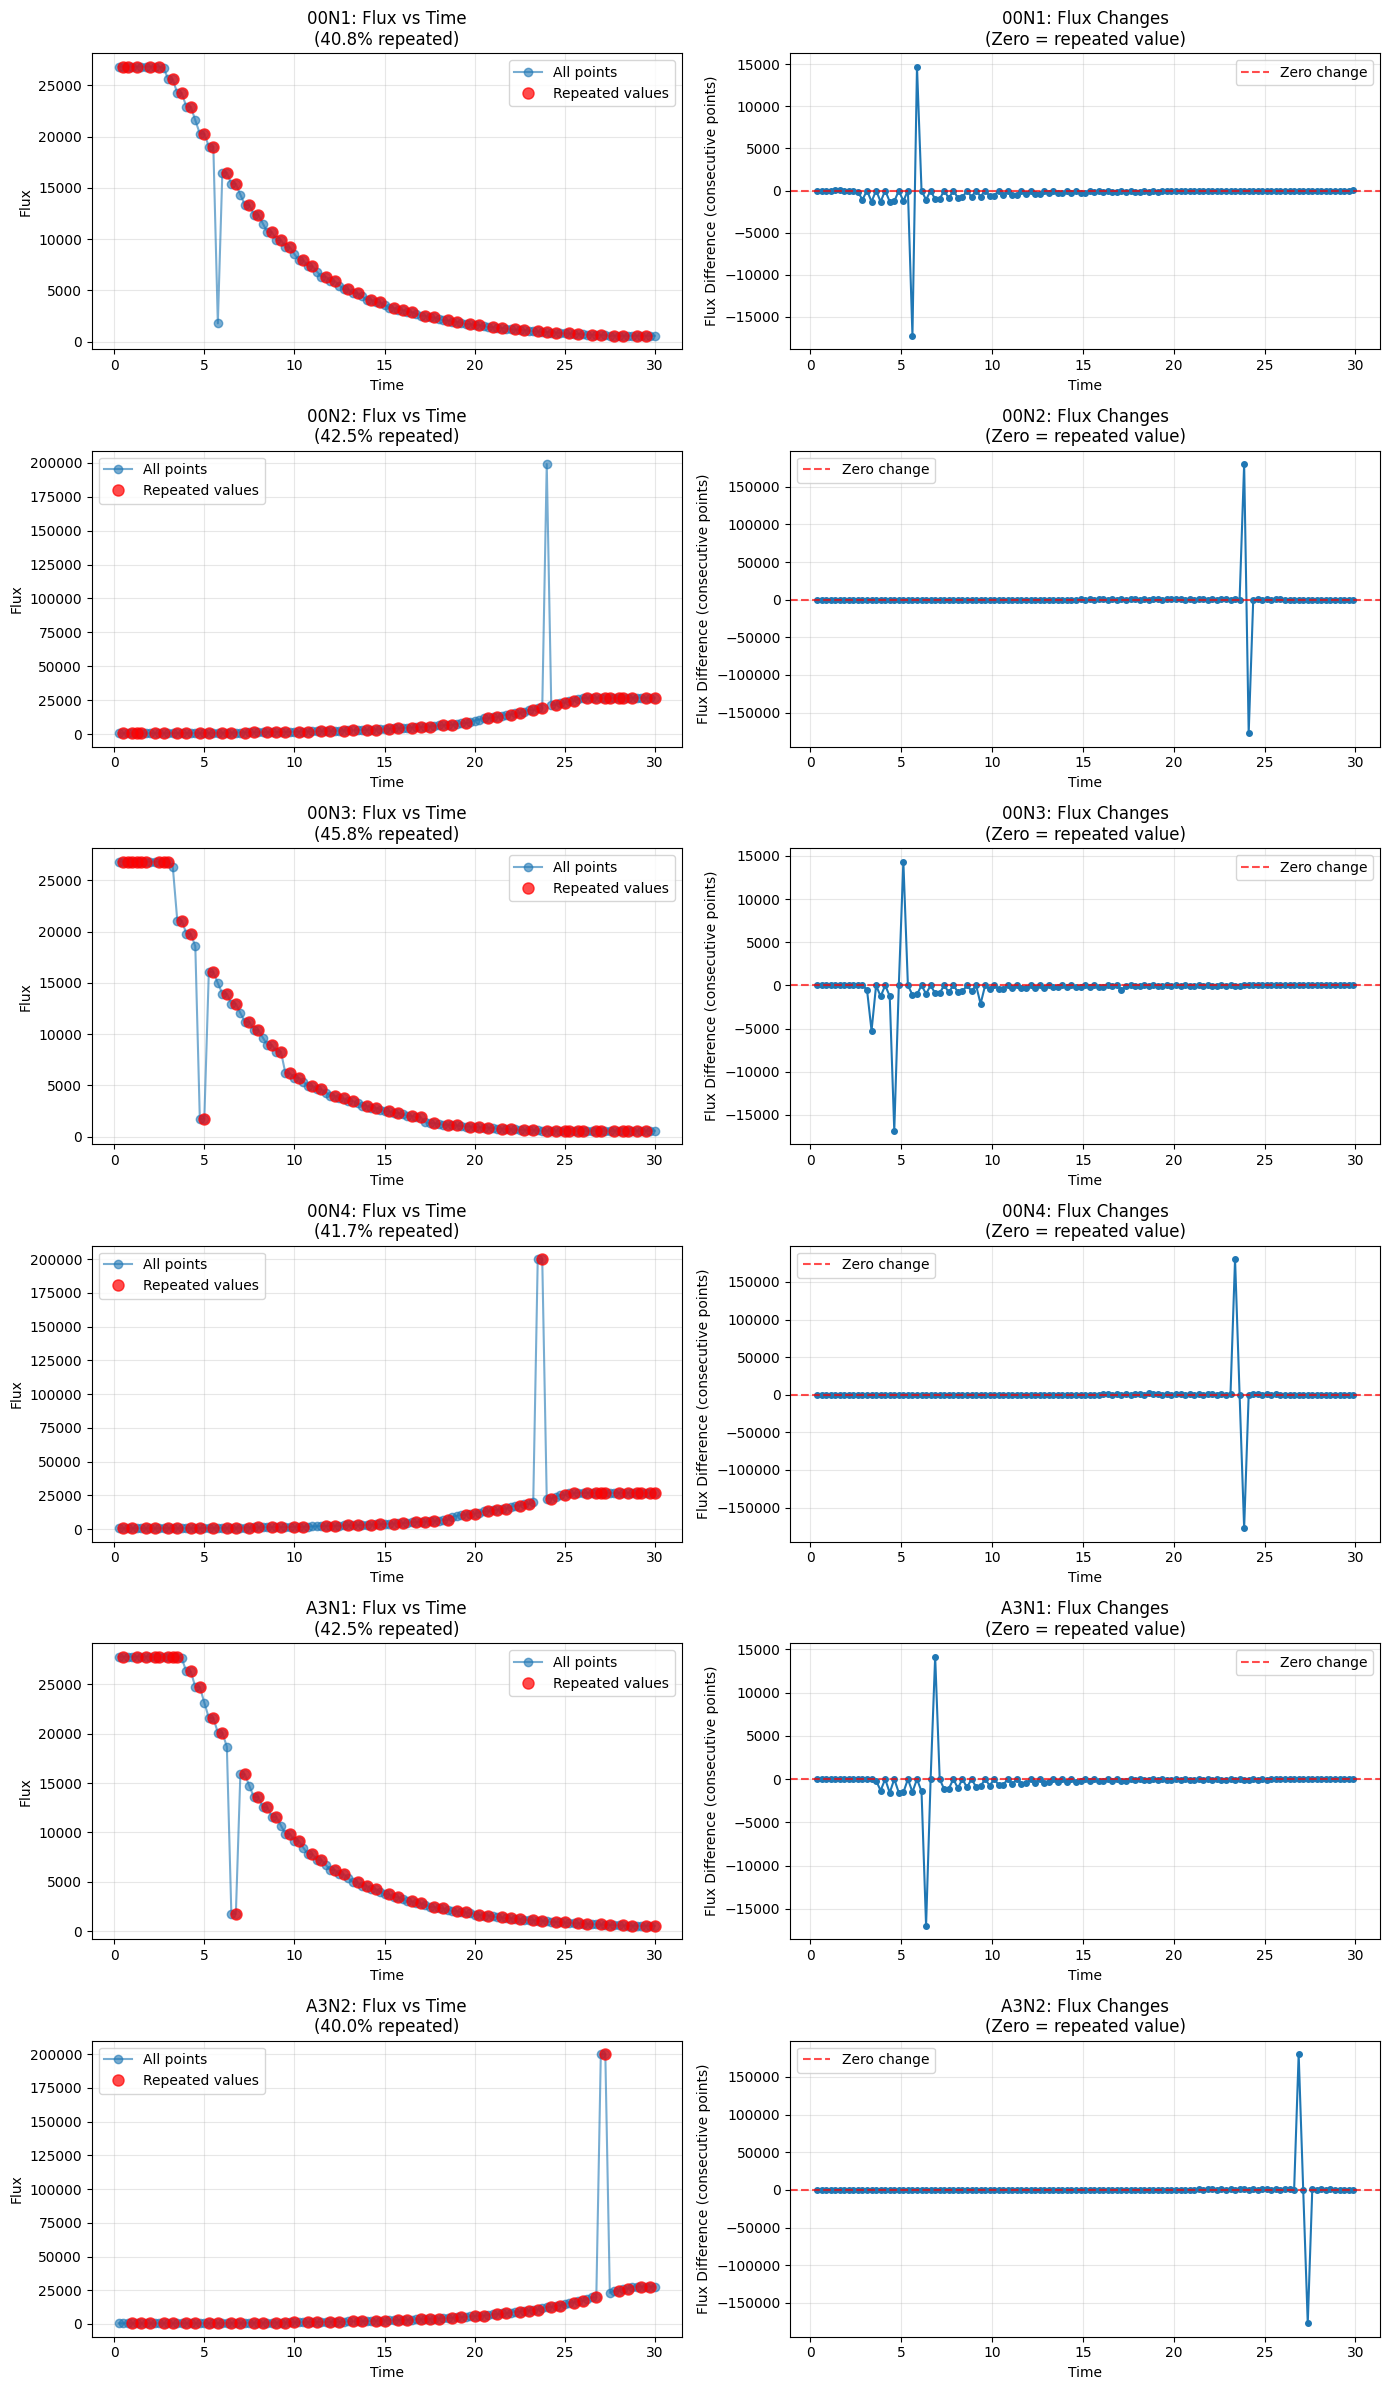

In [4]:
    # Analyze
    results = analyze_repeated_flux(data_dict)
    
    # Print summary
    #print_summary_report(results)
    
    # Plot
    fig = plot_repeated_flux_analysis(data_dict, results)
    print("\nPlot saved to 'repeated_flux_analysis.png'")
    plt.show()


Plot saved to 'repeated_flux_analysis.png'


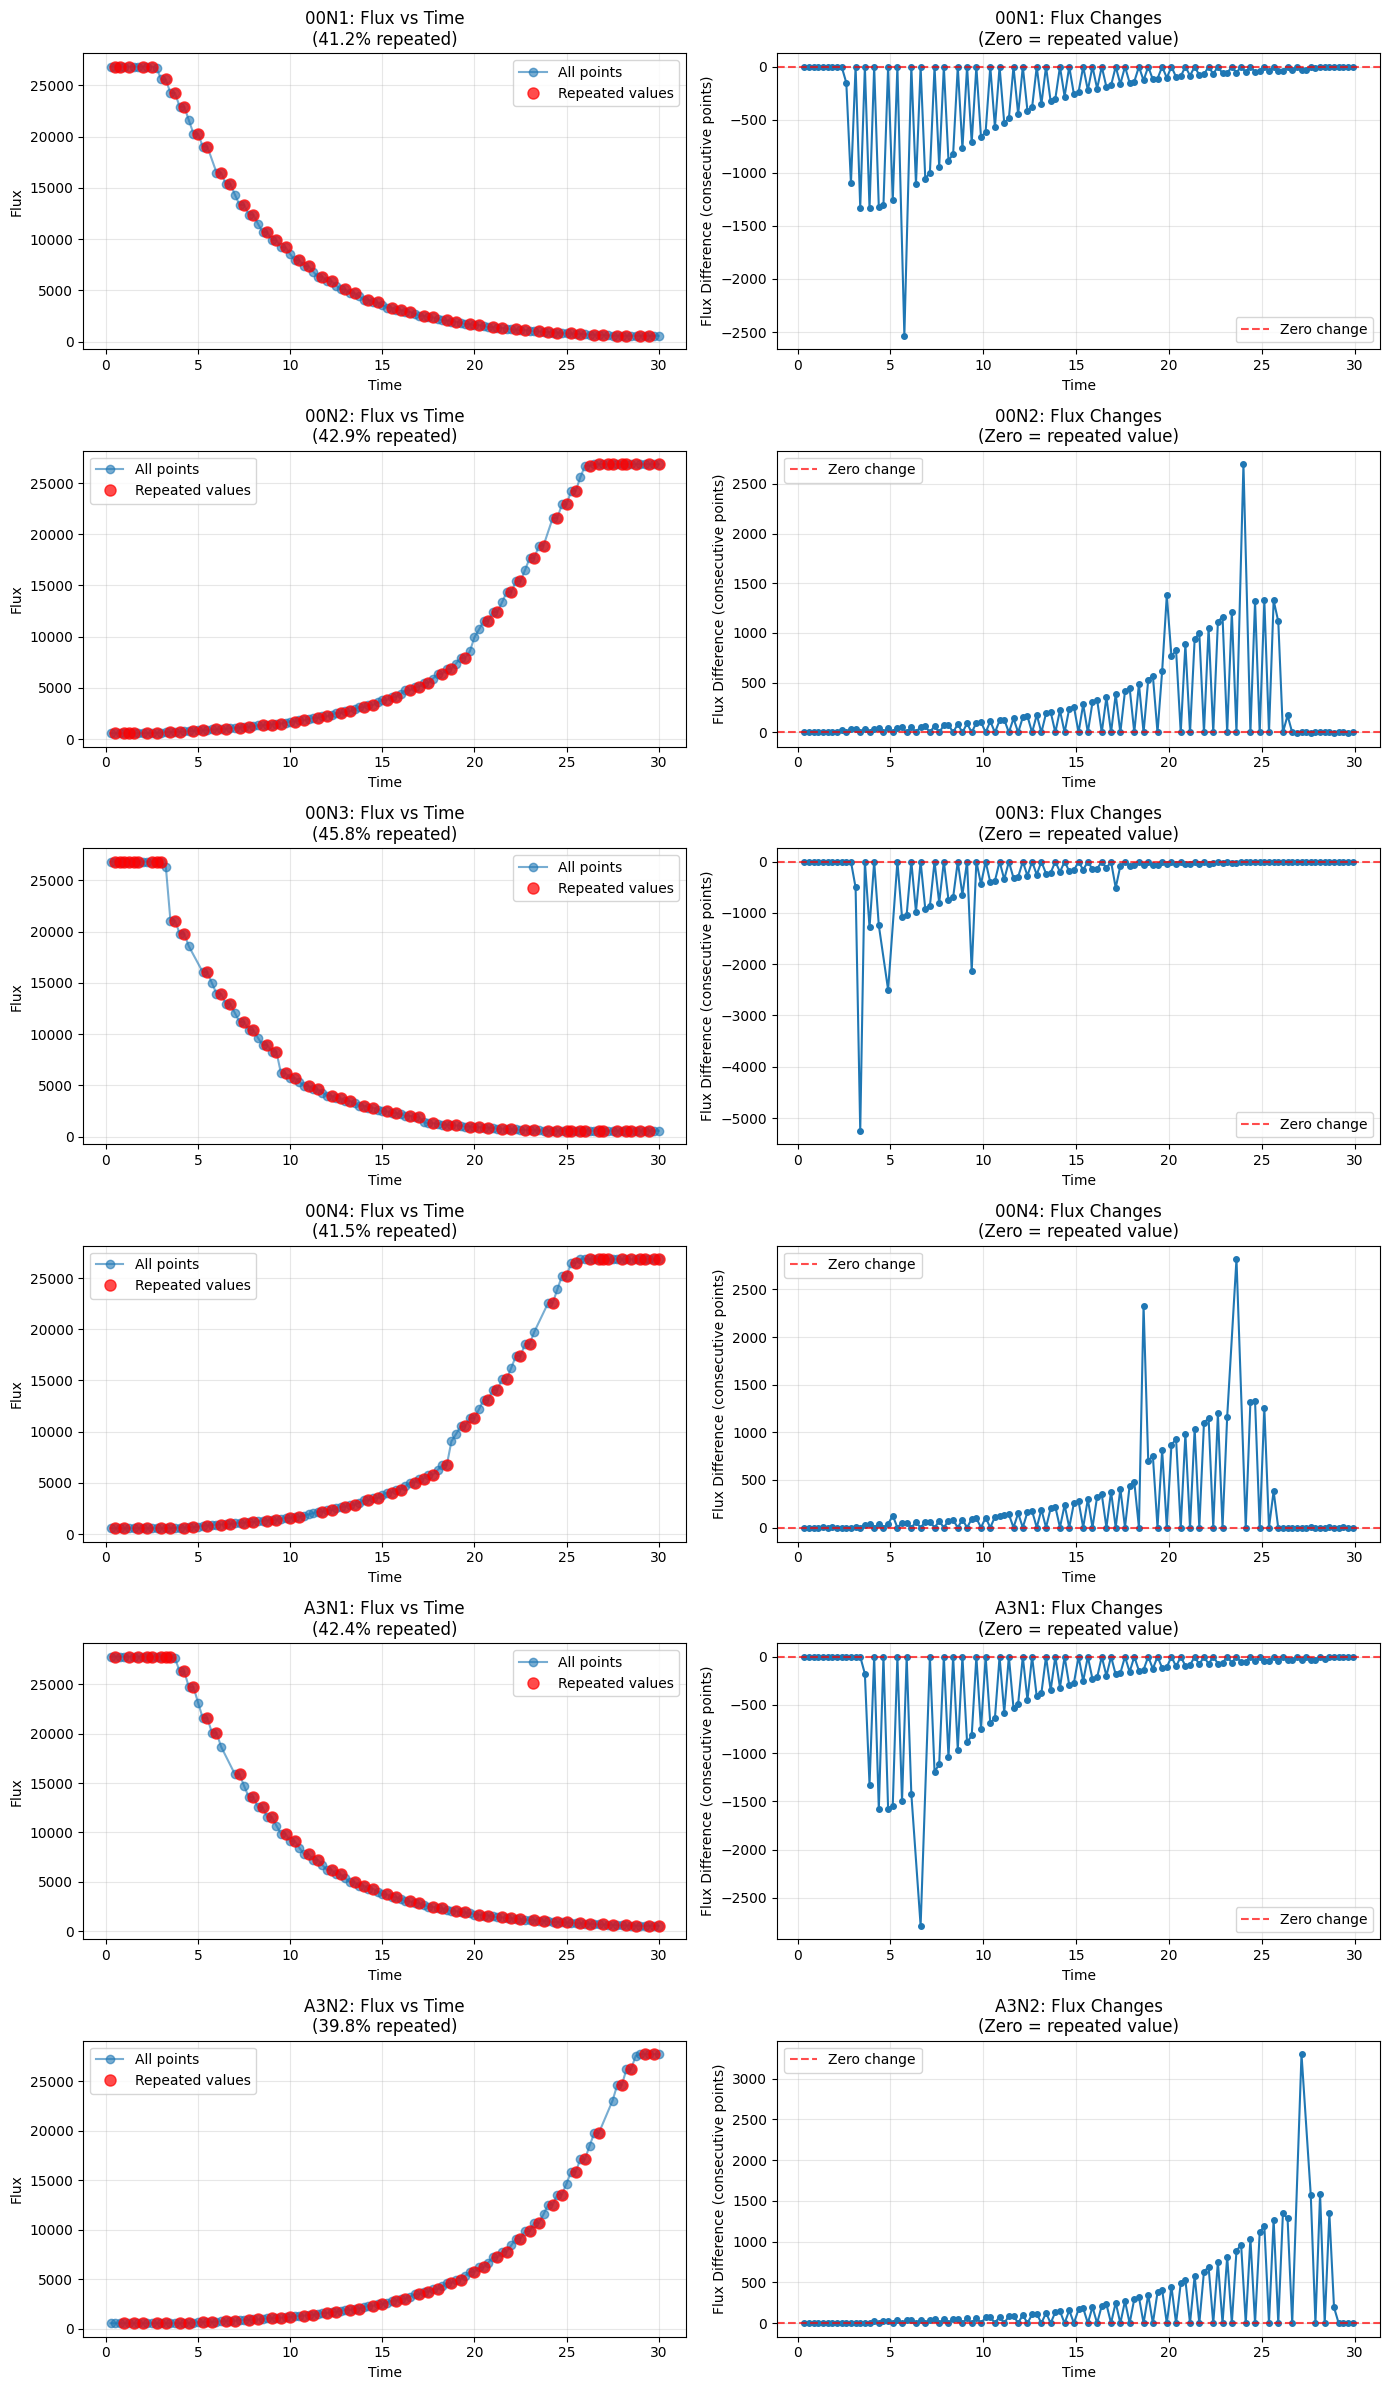

In [5]:
    # Analyze
    results = analyze_repeated_flux(clean_data_dict)
    
    # Print summary
    #print_summary_report(results)
    
    # Plot
    fig = plot_repeated_flux_analysis(clean_data_dict, results)
    print("\nPlot saved to 'repeated_flux_analysis.png'")
    plt.show()